In [2]:
import rasterio
import csv
from rasterio.plot import show
from rasterio.transform import from_origin
import pandas as pd
import networkx as nx
import math
import random
from collections import defaultdict
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Preprocessing

## Preprocessing Gowalla

In [8]:
pop_density_file = "../population/gpw_v4_population_density_rev11_2020_15_min.tif"
with rasterio.open(pop_density_file) as dataset:
    print(dataset.meta)

    input_file = "../gowalla_data/edges_locations.txt"
    data = {}

    for line in open(input_file, "r"):
        user_id, timestamp, latitude, longitude, _ = line.split()
        user_id = int(user_id)
        latitude = float(latitude)
        longitude = float(longitude)

        if user_id not in data:
            if -90 <= latitude <= 90 and -180 <= longitude <= 180:
                try:
                    row, col = dataset.index(longitude, latitude)
                    pop_density = dataset.read(1)[
                        row, col
                    ]

                    data[user_id] = (latitude, longitude, pop_density)
                except IndexError:
                    print(
                        f"Skipping user {user_id} at ({latitude}, {longitude}) - Out of bounds"
                    )
            else:
                print(
                    f"Skipping user {user_id} at ({latitude}, {longitude}) - Coordinates out of valid range"
                )

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028230607370965e+38, 'width': 1440, 'height': 720, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.25, 0.0, -180.0,
       0.0, -0.25, 89.99999999999991)}
Skipping user 132930 at (402.091872, 153.116143) - Coordinates out of valid range
Skipping user 132930 at (402.026603, 153.026752) - Coordinates out of valid range
Skipping user 132930 at (402.026603, 153.026752) - Coordinates out of valid range


In [23]:
output_file = "../gowalla_data/locations_with_population.csv"
with open(output_file, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["user_id", "latitude", "longitude", "population_density"])
    for user_id, (lat, lon, pop_density) in data.items():
        writer.writerow([user_id, lat, lon, pop_density])

print(f"Data has been successfully written to {output_file}")

Data has been successfully written to ../gowalla_data/locations_with_population.csv


In [ ]:
## Experimentations with pop_density
pop_density_file_15min = "../population/gpw_v4_population_density_rev11_2020_15_min.tif"

with rasterio.open(pop_density_file_15min) as dataset:
    print(dataset.meta)

    latitude, longitude = 40.7128, -74.0060  # New York City coordinates
    row, col = dataset.index(longitude, latitude)
    pop_density = dataset.read(1)[row, col]
    print(f"Population density at New York City: {pop_density}")

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028230607370965e+38, 'width': 1440, 'height': 720, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.25, 0.0, -180.0,
       0.0, -0.25, 89.99999999999991)}
Population density at New York City: 4588.83349609375


In [12]:
df = pd.read_csv(output_file)
df.head()

,user_id,latitude,longitude,population_density
0,0,30.235909,-97.795140,549.16534
1,1,48.863379,2.333329,11588.53400
2,2,34.043023,-118.267157,3767.41300
3,4,37.782605,-122.407608,3406.03610
4,5,40.761177,-73.986871,8311.10700


## Preprocessing Foursquare

In [24]:
pop_density_file = "../population/gpw_v4_population_density_rev11_2020_15_min.tif"

input_file = "../foursquare_data/data_with_twitter.csv"
output_file = "../foursquare_data/data_with_population.csv"

df = pd.read_csv(input_file)

data = {}

with rasterio.open(pop_density_file) as dataset:
    print("Raster metadata:", dataset.meta)

    for index, row in df.iterrows():
        user_id = row["User ID"]
        latitude = row["Latitude"]
        longitude = row["Longitude"]

        if -90 <= latitude <= 90 and -180 <= longitude <= 180:
            try:
                raster_row, raster_col = dataset.index(longitude, latitude)
                pop_density = dataset.read(1)[raster_row, raster_col]

                data[user_id] = {
                    "latitude": latitude,
                    "longitude": longitude,
                    "degree": row["Degree"],
                    "clustering_coefficient": row["ClusteringCoefficient"],
                    "gender": row["Gender"],
                    "twitter_friend_count": row["TwitterFriendCount"],
                    "twitter_follower_count": row["TwitterFollowerCount"],
                    "population_density": pop_density,
                }
            except IndexError:
                print(
                    f"Skipping user {user_id} at ({latitude}, {longitude}) - Out of bounds"
                )
        else:
            print(
                f"Skipping user {user_id} at ({latitude}, {longitude}) - Coordinates out of valid range"
            )

Raster metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028230607370965e+38, 'width': 1440, 'height': 720, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.25, 0.0, -180.0,
       0.0, -0.25, 89.99999999999991)}


In [25]:
with open(output_file, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(
        [
            "user_id",
            "latitude",
            "longitude",
            "degree",
            "clustering_coefficient",
            "gender",
            "twitter_friend_count",
            "twitter_follower_count",
            "population_density",
        ]
    )

    for user_id, user_data in data.items():
        writer.writerow(
            [
                user_id,
                user_data["latitude"],
                user_data["longitude"],
                user_data["degree"],
                user_data["clustering_coefficient"],
                user_data["gender"],
                user_data["twitter_friend_count"],
                user_data["twitter_follower_count"],
                user_data["population_density"],
            ]
        )

print(f"Data has been successfully written to {output_file}")

Data has been successfully written to ../foursquare_data/data_with_population.csv


In [26]:
result_df = pd.read_csv(output_file)
print("\nFirst few rows of the new dataset:")
print(result_df.head())


First few rows of the new dataset:
   user_id   latitude   longitude  degree  clustering_coefficient  gender  \
0   224351  40.733596  -74.003139       2                     0.0    male   
1   131527  34.010279 -118.495523       0                     0.0    male   
2   262430  34.075314 -118.253499       0                     0.0    male   
3   199229  40.718363  -73.990817       0                     0.0    male   
4    21174  40.741632  -73.978377       0                     0.0  female   

   twitter_friend_count  twitter_follower_count  population_density  
0                   142                     168           4588.8335  
1                   656                     249           3767.4130  
2                   696                      97           3767.4130  
3                   377                     218          11586.3670  
4                   596                     671          11586.3670  


# Creating Graph

## Graph for Gowalla

In [15]:
nodes_df = pd.read_csv("../gowalla_data/locations_with_population.csv")

edges_df = pd.read_csv("../gowalla_data/edges.txt", sep="\t", names=["source", "target"])

G = nx.Graph()

for index, row in nodes_df.iterrows():
    if not pd.isna(row["latitude"]) and not pd.isna(row["longitude"]):
        G.add_node(
            row["user_id"],
            latitude=row["latitude"],
            longitude=row["longitude"],
            population_density=row["population_density"],
        )

for index, row in edges_df.iterrows():
    if G.has_node(row["source"]) and G.has_node(row["target"]):
        G.add_edge(row["source"], row["target"])

# Deterministic Methods

In [16]:
def haversine_distance(node1, node2):
    # convert from degrees to radians
    lat1 = math.radians(node1["latitude"])
    lon1 = math.radians(node1["longitude"])
    lat2 = math.radians(node2["latitude"])
    lon2 = math.radians(node2["longitude"])

    # haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = (
        math.sin(dlat / 2) ** 2
        + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    )
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    radius = 6371  # earth's radius in kilometers
    distance = radius * c
    return distance

In [17]:
max_degree = max(dict(G.degree()).values())

In [18]:
MAX_USER_ID = 196590
MIN_USER_ID = 0
MAX_HOPS = 20
ALPHA = 0.001

In [19]:
def degree_only_search(G, start, target, max_hops):
    return generic_search(
        G, start, target, max_hops, lambda neighbor, _: G.degree(neighbor)
    )


def geography_only_search(G, start, target, max_hops):
    target_data = G.nodes[target]
    return generic_search(
        G,
        start,
        target,
        max_hops,
        lambda neighbor, _: -haversine_distance(G.nodes[neighbor], target_data),
    )


def geography_population_search(G, start, target, max_hops):
    target_data = G.nodes[target]
    return generic_search(
        G,
        start,
        target,
        max_hops,
        lambda neighbor, _: -haversine_distance(G.nodes[neighbor], target_data)
        / (1 + ALPHA * G.nodes[neighbor]["population_density"]),
    )


def evn_search(G, start, target, max_hops):
    target_data = G.nodes[target]
    max_degree = max(dict(G.degree()).values())
    return generic_search(
        G,
        start,
        target,
        max_hops,
        lambda neighbor, _: (G.degree(neighbor) / max_degree)
        * (1 / (haversine_distance(G.nodes[neighbor], target_data) + 1)),
    )


def enhanced_evn_search(G, start, target, max_hops):
    target_data = G.nodes[target]
    max_degree = max(dict(G.degree()).values())
    return generic_search(
        G,
        start,
        target,
        max_hops,
        lambda neighbor, _: (G.degree(neighbor) / max_degree)
        * (1 / (haversine_distance(G.nodes[neighbor], target_data) + 1))
        / (1 + ALPHA * G.nodes[neighbor]["population_density"]),
    )


def generic_search(G, start, target, max_hops, score_func):
    current_node = start
    visited = set()
    path = [current_node]
    hops = 0

    while hops < max_hops:
        if current_node == target:
            return path

        visited.add(current_node)
        neighbors = [n for n in G.neighbors(current_node) if n not in visited]

        if not neighbors:
            return None

        if target in neighbors:
            path.append(target)
            return path 

        scores = {}
        for neighbor in neighbors:
            neighbor_data = G.nodes[neighbor]
            if "latitude" not in neighbor_data or "longitude" not in neighbor_data:
                print(f"Skipping node {neighbor} due to missing location data")
                continue

            scores[neighbor] = score_func(neighbor, current_node)

        if not scores:
            return None  

        current_node = max(scores, key=scores.get)
        path.append(current_node)
        hops += 1

    return None 

# Evaluation

In [21]:
def run_tests(G, num_tests=100):
    results = defaultdict(list)
    strategies = {
        "Degree Only": degree_only_search,
        "Geography Only": geography_only_search,
        "Geography + Population": geography_population_search,
        "EVN": evn_search,
        "Enhanced EVN": enhanced_evn_search,
    }

    for strategy_name, strategy_func in strategies.items():
        success_count = 0
        total_hops = 0
        for _ in range(num_tests):
            start = random.randint(MIN_USER_ID, MAX_USER_ID)
            target = random.randint(MIN_USER_ID, MAX_USER_ID)

            if (
                not G.has_node(start)
                or not G.has_node(target)
                or not nx.has_path(G, start, target)
            ):
                continue  

            path = strategy_func(G, start, target, MAX_HOPS)
            if path:
                success_count += 1
                total_hops += len(path) - 1 

        success_rate = success_count / num_tests
        avg_hops = total_hops / success_count if success_count else 0
        results["Strategy"].append(strategy_name)
        results["Success Rate"].append(success_rate)
        results["Average Hops"].append(avg_hops)

    return pd.DataFrame(results)




## Results Gowalla

In [22]:
# Run tests and plot results
results_df = run_tests(G, num_tests=5000)

In [92]:
print (results_df)

                 Strategy  Success Rate  Average Hops
0             Degree Only        0.0564      5.390071
1          Geography Only        0.0246      8.983740
2  Geography + Population        0.0218      9.027523
3                     EVN        0.0806      7.761787
4            Enhanced EVN        0.0732      7.756831


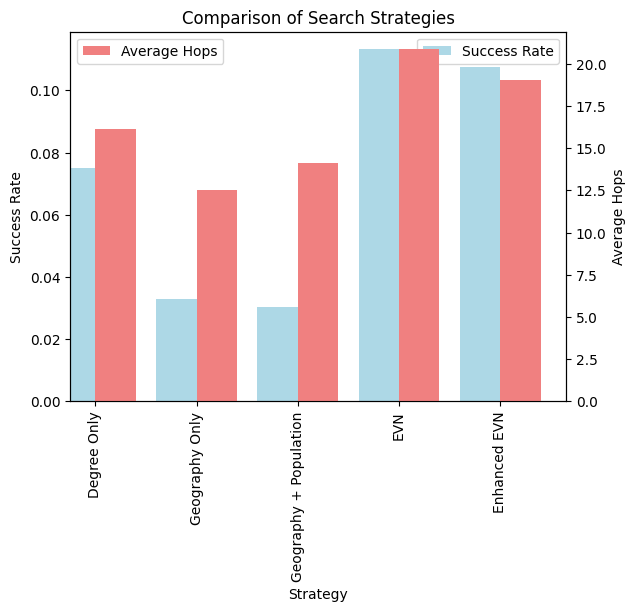

In [52]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
results_df.plot(
    x="Strategy",
    y="Success Rate",
    kind="bar",
    ax=ax1,
    color="lightblue",
    position=1,
    width=0.4,
)
results_df.plot(
    x="Strategy",
    y="Average Hops",
    kind="bar",
    ax=ax2,
    color="lightcoral",
    position=0,
    width=0.4,
)

ax1.set_ylabel("Success Rate")
ax2.set_ylabel("Average Hops")
plt.title("Comparison of Search Strategies")
plt.show()

## Results Foursquare